<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import yfinance as yf

In [8]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [9]:
# get historical market data
hist = cat.history(period="max")

In [10]:
hist.drop(columns=["Volume", "Stock Splits", "Dividends"], inplace=True)

<Axes: xlabel='Date'>

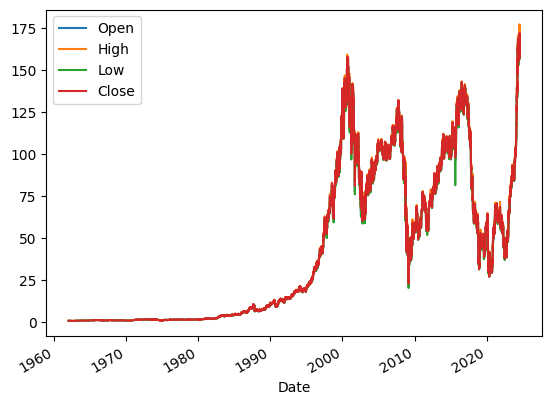

In [11]:
hist.reset_index().plot(x="Date",y=hist.columns)

In [12]:
hist.describe()

,Open,High,Low,Close
count,15749.000000,15749.000000,15749.000000,15749.000000
mean,41.192472,41.630597,40.733393,41.188287
std,44.881839,45.332534,44.419423,44.886000
min,0.469600,0.477004,0.459024,0.469601
25%,1.399638,1.409739,1.388530,1.399638
50%,17.362539,17.480657,17.173559,17.386162
75%,78.996965,79.908890,78.144125,79.072937
max,171.500000,177.199997,167.815951,172.000000


## Moving Average Derivation

Suppose we have a time series:

\begin{align}
x_t \hspace{2cm} t=0,1,..,T-1
\end{align}


And its cumulative sum:

\begin{align}
c_t = \sum_{i=0}^t x_i
\end{align}

And we want to compute the moving average at time step $t$, by considering the $w$ previous time steps ($t$ is also included):

\begin{align}
\overline{x}_t = \frac{1}{w} \sum_{i = t-w+1}^t x_i \hspace{2cm} \, for \, t = w-1,...,T-1.
\end{align}

The cumulative sum at time $t$ can be written as:

\begin{align}
c_t = \sum_{i=0}^t x_i = \sum_{i=0}^{t-w} x_i \, + \, \sum_{i=t-w+1}^{t} x_i = c_{t-w} \, + \, w\, \overline{x}_t
\end{align}

The previous formula is defined for $t=w,...,T-1$ as can be seen by inspecting the upper extreme of the first sum and considering that $x_t$ is definited for $t\ge0$, therefore:

\begin{align}
\overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{align}

To find $\overline{x}_t$ at time $t=w-1$ we use the definition:

\begin{align}
\overline{x}_{w-1} = \frac{1}{w} \sum_{i = (w-1)-w+1}^{w-1} x_i = \frac{1}{w} \sum_{i = 0}^{w-1} x_i = \frac{1}{w} c_{w-1}.
\end{align}

Overall, the moving average can be computed via:

\begin{cases}
      \overline{x}_{w-1} = \frac{1}{w} c_{w-1}\\
      \overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{cases}


### Algorithm definition

If we want to use a unique array called mov we can implement the following algorithm:

1. Define variable **mov** as the cumulative average.
2. Modify the elemnts of the array mov from the index $w$ by using
   the difference:
   
   **mov[w:] = mov[w:] - mov[:-w]**

3. Note that mov[w-1] has still the initial value equal to the
   cumulative sum at $t=w-1$ therefore we return the array:

   **(1/w)  mov[w-1:]**


This algorithm is implemented in the function moving_average_forecast:

In [13]:
import numpy as np
import pandas as pd

def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)

  # This is necessary because to subtract two pandas series it is necessary
  # That both series have the same index. Therefore we force the series
  # mov[window_size:] and mov[:-window_size] to have the same index

  index = pd.Index(
      list(
          range(mov.size - window_size)
      )
  )

  mov[window_size:] = mov[window_size:].set_axis(index)- mov[:-window_size].set_axis(index)

  return mov[window_size - 1:] / window_size

In [52]:
window_size = 2

for col in hist.columns:
  mov_average_col = col + "_mov_avg"
  hist[mov_average_col] = moving_average_forecast(hist[col], window_size)

<Axes: xlabel='Date'>

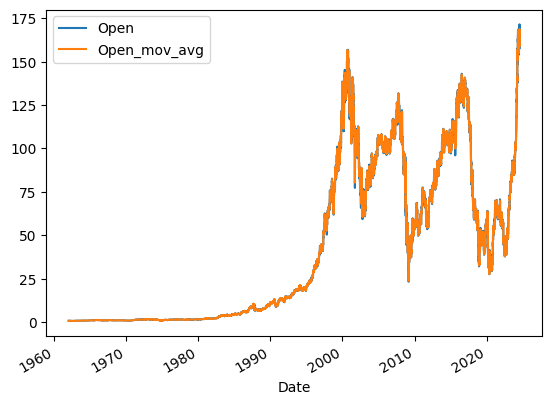

In [53]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_mov_avg"])

In [54]:
# Computation of the Root Mean Square Error (RMSE)
y = hist["Open"]
y_pred = hist["Open_mov_avg"]

RMSE = np.sqrt(np.sum(np.square(y - y_pred)))

In [55]:
RMSE

67.44047929525122

### First Difference

The first difference is defined as:
$d_t = x_t - x_{t-q} \hspace{2cm} t=q,..., T-1$

Therefore it can be implemenentate in the function diff_series following the algoritm:

1. Define the original series as the variable **series**

2. Return the difference **series[q:] - series[:-t0]**